In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys

notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, os.pardir))
print(f"notebook_dir: {notebook_dir}")
print(f"Calculated project_root: {project_root}")
print(f"Current sys.path (before modification): {sys.path}")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

notebook_dir: d:\02_Projects\Dev\ReflectoLearn\notebooks
Calculated project_root: d:\02_Projects\Dev\ReflectoLearn
Current sys.path (before modification): ['C:\\Users\\isaac\\AppData\\Roaming\\uv\\python\\cpython-3.12.11-windows-x86_64-none\\python312.zip', 'C:\\Users\\isaac\\AppData\\Roaming\\uv\\python\\cpython-3.12.11-windows-x86_64-none\\DLLs', 'C:\\Users\\isaac\\AppData\\Roaming\\uv\\python\\cpython-3.12.11-windows-x86_64-none\\Lib', 'C:\\Users\\isaac\\AppData\\Roaming\\uv\\python\\cpython-3.12.11-windows-x86_64-none', 'd:\\02_Projects\\Dev\\ReflectoLearn\\.venv', '', 'd:\\02_Projects\\Dev\\ReflectoLearn\\.venv\\Lib\\site-packages', 'D:\\02_Projects\\Dev\\ReflectoLearn\\src', 'd:\\02_Projects\\Dev\\ReflectoLearn\\.venv\\Lib\\site-packages\\win32', 'd:\\02_Projects\\Dev\\ReflectoLearn\\.venv\\Lib\\site-packages\\win32\\lib', 'd:\\02_Projects\\Dev\\ReflectoLearn\\.venv\\Lib\\site-packages\\Pythonwin']


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from reflectolearn.processing.fitting import (
    estimate_thc,
    func_gauss,
    func_gauss3_with_noise,
    func_noise,
    preprocess_xrr,
    tth2qz_by_energy,
    xrr_fft,
)
from reflectolearn.processing.preprocess import remove_q4_decay
from reflectolearn.processing.simulate import add_xrr_noise, make_multifilm


In [51]:
import random

from scipy.optimize import curve_fit

from reflectolearn.math_utils import apply_poisson_noise, get_background_noise


def multi_gaussian_fitting(x_fit, y_fit, p0):
    # ----------------------- Fit -----------------------
    bounds = (0, np.inf)
    popt, pcov = curve_fit(func_gauss3_with_noise, x_fit, y_fit, p0=p0, bounds=bounds)

    return popt, pcov


def add_noise(R):
    N = len(R)
    R_poisson = apply_poisson_noise(R, s=10 ** 10)
    uniform_noise = np.random.uniform(0.05, 0.1, N)
    background_noise = get_background_noise(N, -12, -9)
    curve_scaling = np.random.uniform(0.99, 1.01)
    return R_poisson * uniform_noise * curve_scaling + background_noise


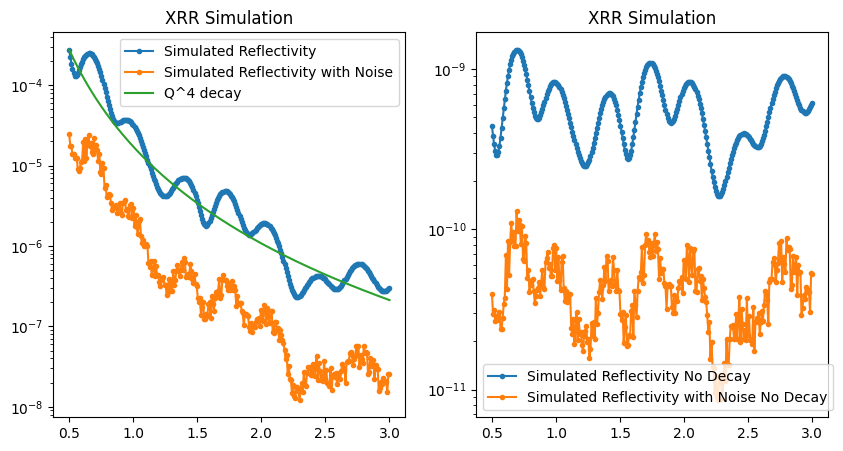

In [52]:
# -----------------------
# 1. 데이터 생성
# -----------------------
beam_energy = 8.04751  # keV
tth = np.linspace(0.5, 3, 300)  # rad
q = tth2qz_by_energy(tth, beam_energy)

# 2층 박막 시뮬레이션 (기판 + 2개 필름)
data = make_multifilm(2, q, add_noise=False)
R = data["R"]
R_noise = add_noise(R)

R_no_q_decay = remove_q4_decay(q, R)
R_noise_no_q_decay = remove_q4_decay(q, R_noise)
decay = 1 / remove_q4_decay(q, np.full_like(q, 1))
decay = decay / decay[0] * R.max()
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].semilogy(tth, R, ".-", label="Simulated Reflectivity")
ax[0].semilogy(tth, R_noise, ".-", label="Simulated Reflectivity with Noise")
ax[0].semilogy(tth, decay, "-", label="Q^4 decay")
ax[0].set_title("XRR Simulation")
ax[0].legend()

ax[1].semilogy(tth, R_no_q_decay, ".-", label="Simulated Reflectivity No Decay")
ax[1].semilogy(tth, R_noise_no_q_decay, ".-", label="Simulated Reflectivity with Noise No Decay")
ax[1].set_title("XRR Simulation")
ax[1].legend()

plt.show()

Estimated critical q: 0.6212


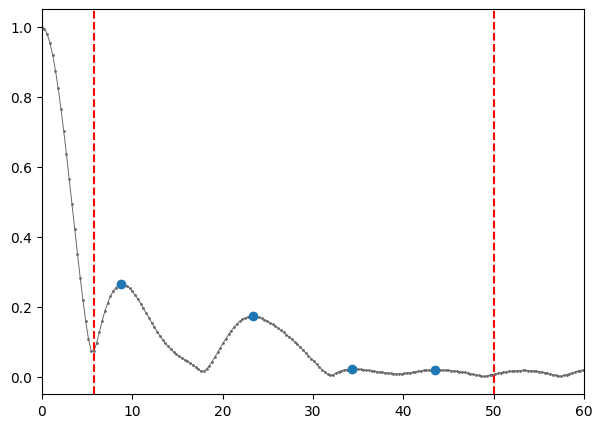

In [59]:
from scipy.signal import argrelextrema

x_upper_bound = 50

crit_q = estimate_thc(tth, R_noise_no_q_decay)
print(f"Estimated critical q: {crit_q:.4f}")

# FFT
dat = np.stack([tth, R_noise_no_q_decay], axis=1)
xproc, yproc = preprocess_xrr(dat, crit_q)
x_fft, y_fft = xrr_fft(xproc, yproc, window=2, n=10000)
y_fft_norm = y_fft / y_fft[0]

idx_local_max = argrelextrema(y_fft_norm[x_fft < x_upper_bound], np.greater)

# fitting range
mask = (x_fft < x_upper_bound) & (x_fft > 0.5)
x_fit, y_fit = x_fft[mask], y_fft_norm[mask]

y_diff = np.diff(y_fit)
# First increasing index
under_bound_index = np.where(y_diff > -0.005)[0][0] + 1
# y_diff_diff = np.diff(np.diff(y_diff))
# print(np.where(y_diff_diff < 0))
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(7, 5))
ax.plot(x_fft, y_fft_norm, "o-", ms=1, lw=0.7, color="dimgrey", label="FFT data")
ax.plot(x_fft[idx_local_max], y_fft_norm[idx_local_max], "o", label="local max")
ax.axvline(x=x_fit[under_bound_index], color='r', linestyle='--')
ax.axvline(x=x_upper_bound, color='r', linestyle='--')
ax.set_xlim(0, x_upper_bound*1.2)
plt.show()

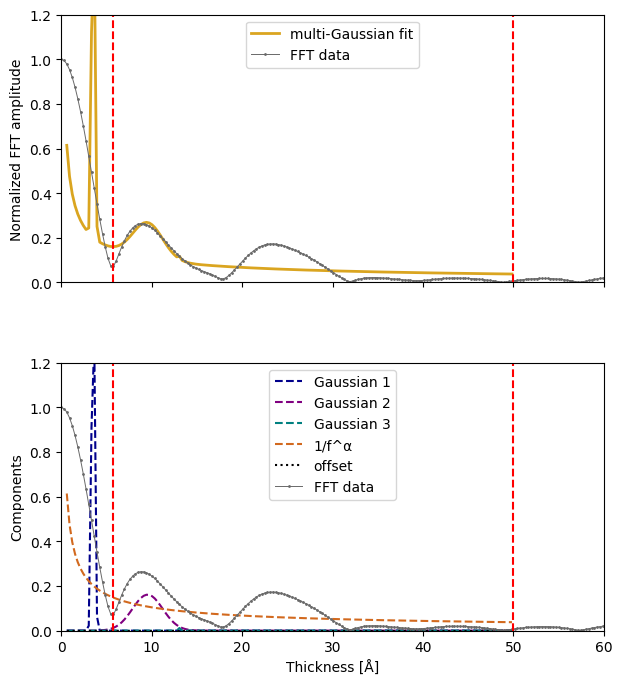

>>> Multi-Gaussian fit results
- G1: amp=0.16, pos≈9.54 Å, w=3.94
- G2: amp=1.69, pos≈3.53 Å, w=0.39
- G3: amp=0.53, pos≈13.07 Å, w=0.00
- Noise: amp=4.48e-01, exp=0.63, offset=1.40e-16


In [54]:
p0 = [0.2, 0.3, 0.2, 7, 0.3, 0.2, 13, 0.3, 1, 2, 0.001]
popt, pcov = multi_gaussian_fitting(x_fit[under_bound_index:], y_fit[under_bound_index:], p0)

# ----------------------- Plot -----------------------
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7, 8))

# (상단: 전체 fit vs 데이터)
ax[0].plot(x_fit, func_gauss3_with_noise(x_fit, *popt), "-", color="goldenrod", lw=2, label="multi-Gaussian fit")
ax[0].plot(x_fft, y_fft_norm, "o-", ms=1, lw=0.7, color="dimgrey", label="FFT data")
ax[0].axvline(x=x_fit[under_bound_index], color='r', linestyle='--')
ax[0].axvline(x=x_upper_bound, color='r', linestyle='--')
ax[0].set_ylabel("Normalized FFT amplitude")
ax[0].legend()

# (하단: component 분리 보기)
ax[1].plot(x_fit, func_gauss(x_fit, *popt[2:5]), "--", color="darkblue", label="Gaussian 1")
ax[1].plot(x_fit, func_gauss(x_fit, popt[0], popt[6] - popt[3], popt[1]), "--", color="purple", label="Gaussian 2")
ax[1].plot(x_fit, func_gauss(x_fit, *popt[5:8]), "--", color="teal", label="Gaussian 3")
ax[1].plot(x_fit, func_noise(x_fit, *popt[8:10]), "--", color="chocolate", label="1/f^α")
ax[1].plot(x_fit, np.ones_like(x_fit)*popt[10], ":", color="black", label="offset")
ax[1].plot(x_fft, y_fft_norm, "o-", ms=1, lw=0.7, color="dimgrey", label="FFT data")
ax[1].axvline(x=x_fit[under_bound_index], color='r', linestyle='--')
ax[1].axvline(x=x_upper_bound, color='r', linestyle='--')

ax[1].set_xlabel("Thickness [Å]")
ax[1].set_ylabel("Components")
ax[1].legend()

ax[0].set_xlim(0, x_upper_bound*1.2)
ax[1].set_xlim(0, x_upper_bound*1.2)
ax[0].set_ylim(0, 1.2)
ax[1].set_ylim(0, 1.2)
# ax[0].set_yscale('log')
# ax[1].set_yscale('log')
fig.subplots_adjust(hspace=0.3)
plt.show()

# ----------------------- Report -----------------------
print(">>> Multi-Gaussian fit results")
print(f"- G1: amp={popt[0]:.2f}, pos≈{popt[6]-popt[3]:.2f} Å, w={popt[1]:.2f}")
print(f"- G2: amp={popt[2]:.2f}, pos≈{popt[3]:.2f} Å, w={popt[4]:.2f}")
print(f"- G3: amp={popt[5]:.2f}, pos≈{popt[6]:.2f} Å, w={popt[7]:.2f}")
print(f"- Noise: amp={popt[8]:.2e}, exp={popt[9]:.2f}, offset={popt[10]:.2e}")